# Second Notebook: Data Visualization

## 1. Import Libraries: Load essential libraries

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import time
from rapidfuzz import process as rf_process


## 2. Load Data: Import aircrash dataset.

In [3]:
# Load Data
data_path = "../data/updated_Airplane_Crashes.csv"
data = pd.read_csv(data_path, encoding='latin1')

# Inspect Data
print(data.head())
print(data.info())

        Date   Time                            Location  \
0  9/17/1908  17:18            Fort Myer, Virginia, USA   
1   9/7/1909  00:00             Juvisy-sur-Orge, France   
2  7/12/1912   6:30      Atlantic City, New Jersey, USA   
3   8/6/1913  00:00  Victoria, British Columbia, Canada   
4   9/9/1913  18:30                  Over the North Sea   

                 Operator Flight #          Route                 AC Type  \
0    Military - U.S. Army      NaN  Demonstration        Wright Flyer III   
1                     NaN      NaN       Air show          Wright Byplane   
2    Military - U.S. Navy      NaN    Test flight               Dirigible   
3                 Private      NaN            NaN        Curtiss seaplane   
4  Military - German Navy      NaN            NaN  Zeppelin L-1 (airship)   

  Registration cn/ln  Aboard  Aboard Passangers  Aboard Crew  Fatalities  \
0          NaN     1     2.0                1.0          1.0         1.0   
1          SC1   NaN     1.0  

## 3. Trend Analysis Over Time:
**Create a time-series plot to show the number of crashes per year.**

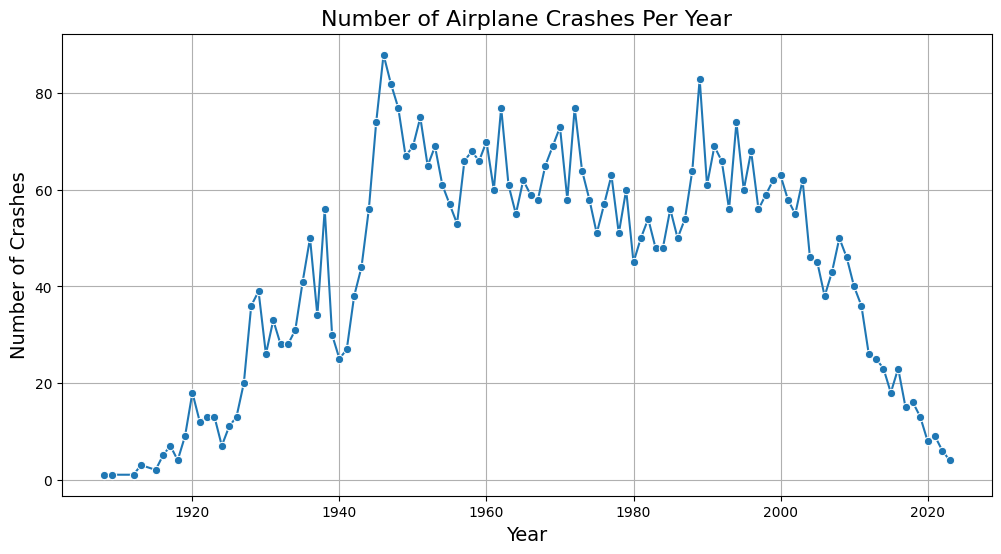

In [4]:
# Trend Analysis Over Time
# Convert the Date column to datetime format if it exists
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['Year'] = data['Date'].dt.year
    
    # Count crashes per year
    yearly_crashes = data.groupby('Year').size().reset_index(name='Crashes')

    # Plot time-series of crashes
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_crashes, x='Year', y='Crashes', marker='o')
    plt.title('Number of Airplane Crashes Per Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Crashes', fontsize=14)
    plt.grid(True)
    plt.show()

## 4. Crashes by Flight Category: 
**Create a bar plot or pie chart to show the distribution of crashes by flight category.**

Classified Operators by Category:
                 Operator  Category
0    Military - U.S. Army  Military
1                     nan   Unknown
2    Military - U.S. Navy  Military
3                 Private   Private
4  Military - German Navy  Military


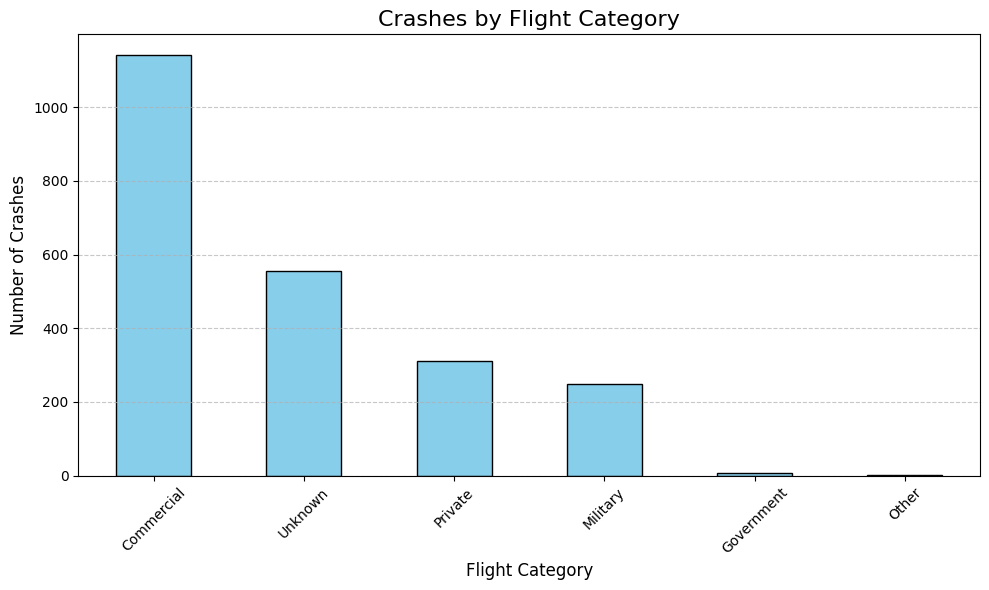

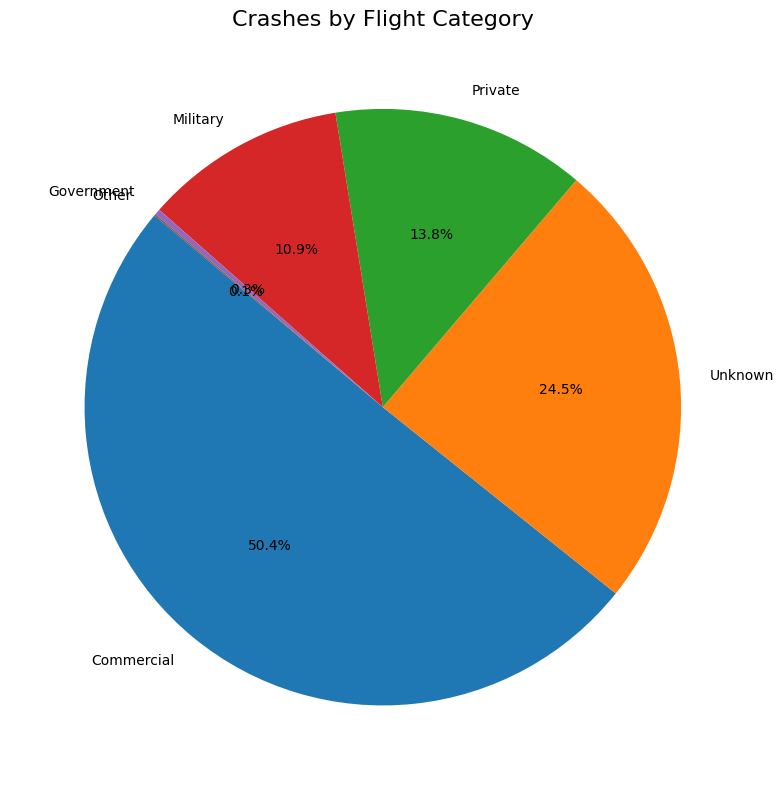

In [8]:
# File paths
operators_file = '../data/unique_operators.txt'  # Replace with your file path
crashes_file = '../data/updated_Airplane_Crashes.csv'  # Replace with your file path

# Step 1: Define expanded categories
categories = {
    'Military': ['Military', 'Air Force', 'Navy', 'Army', 'Marine Corps', 'Defense','NATO'],
    'Private': ['Private', 'Charter', 'Taxi', 'Club', 'Skydiving', 'Service', 'Inc.', 'Helicopter', 'Helicopters', 'Company'],
    'Commercial': ['Aerolift', 'Aviastar', 'Rwandair', 'Wizzair', 'Airlink', 'Azzi',  'Alaska', 'Filair', 'Airlines', 'Airways', 'Lifeflight', 'Aéropro', 'Aeroflot', 'Aeroplane', 'UTAir', 'Flydubai', 'Emirates', 'Aviation', 'Lineas', 'Air', 'Lines', 'Aircraft', 'Transport', 'Cargo', 'Express', 'AirAsia', 'Transasia', 'Airway', 'Airways'],
    'Government': ['Government', 'Police', 'Border', 'State'],
    'Other': ['Historical', 'Research', 'Union', 'Society', 'Mission', 'Educational'],
    'Unknown': []  # Catch-all for unmatched operators
}

# Step 2: Function to classify operators based on keywords
def classify_operator(operator):
    for category, keywords in categories.items():
        if any(keyword.lower() in operator.lower() for keyword in keywords):
            return category
    return 'Unknown'

# Step 3: Read the operators file
with open(operators_file, 'r') as file:
    operators = file.readlines()

# Step 4: Process and classify operators
operators = [op.strip() for op in operators if op.strip()]  # Remove empty lines and strip whitespace
classified_operators = [(op, classify_operator(op)) for op in operators]

# Step 5: Convert to a DataFrame for better visualization
classified_df = pd.DataFrame(classified_operators, columns=['Operator', 'Category'])

# Step 6: Print the classified data
print("Classified Operators by Category:")
print(classified_df.head())

# Step 7: Calculate crash counts by category (for plotting)
crash_counts = classified_df['Category'].value_counts()

# Step 8: Plotting the Bar Chart
plt.figure(figsize=(10, 6))
crash_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Crashes by Flight Category', fontsize=16)
plt.xlabel('Flight Category', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 9: Plotting the Pie Chart
plt.figure(figsize=(8, 8))
crash_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Crashes by Flight Category', fontsize=16)
plt.ylabel('')  # Remove y-label for aesthetics
plt.tight_layout()
plt.show()



**5. Hotspot Map:** Use geographic plotting libraries like Folium or Plotly to create a heatmap of crash locations.

In [19]:
# Step 1: Geocode the location column (City, Country) to get latitude and longitude
geolocator = Nominatim(user_agent="crash_hotspot_map")

# Function to get latitude and longitude from location
def geocode_location(location):
    try:
        # Split the location into city and country
        location_obj = geolocator.geocode(location)
        if location_obj:
            return (location_obj.latitude, location_obj.longitude)
        else:
            return None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None

# Apply the geocoding function to the "Location" column
data[['Latitude', 'Longitude']] = data['Location'].apply(lambda x: pd.Series(geocode_location(x)))

# Step 2: Filter out rows with missing or invalid coordinates
geo_data = data.dropna(subset=['Latitude', 'Longitude'])

# Step 3: Initialize a folium map
crash_map = folium.Map(location=[0, 0], zoom_start=2)  # Global map

# Step 4: Create heatmap data (latitude, longitude)
heat_data = geo_data[['Latitude', 'Longitude']].values.tolist()

# Step 5: Add heatmap to the map
HeatMap(heat_data).add_to(crash_map)

# Step 6: Save and display map
crash_map.save('crash_heatmap.html')  # Save as an HTML file
crash_map  # Display map in Jupyter Notebook (if running there)


Error geocoding Goshen, Indiana, USA: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Goshen%2C+Indiana%2C+USA&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Az-Zubair, Iran: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Az-Zubair%2C+Iran&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding New York, New York, USA: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=New+York%2C+New+York%2C+USA&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Ocean, 800 miles east

### 6. Modeling

**step 1: look at the numbers we have**

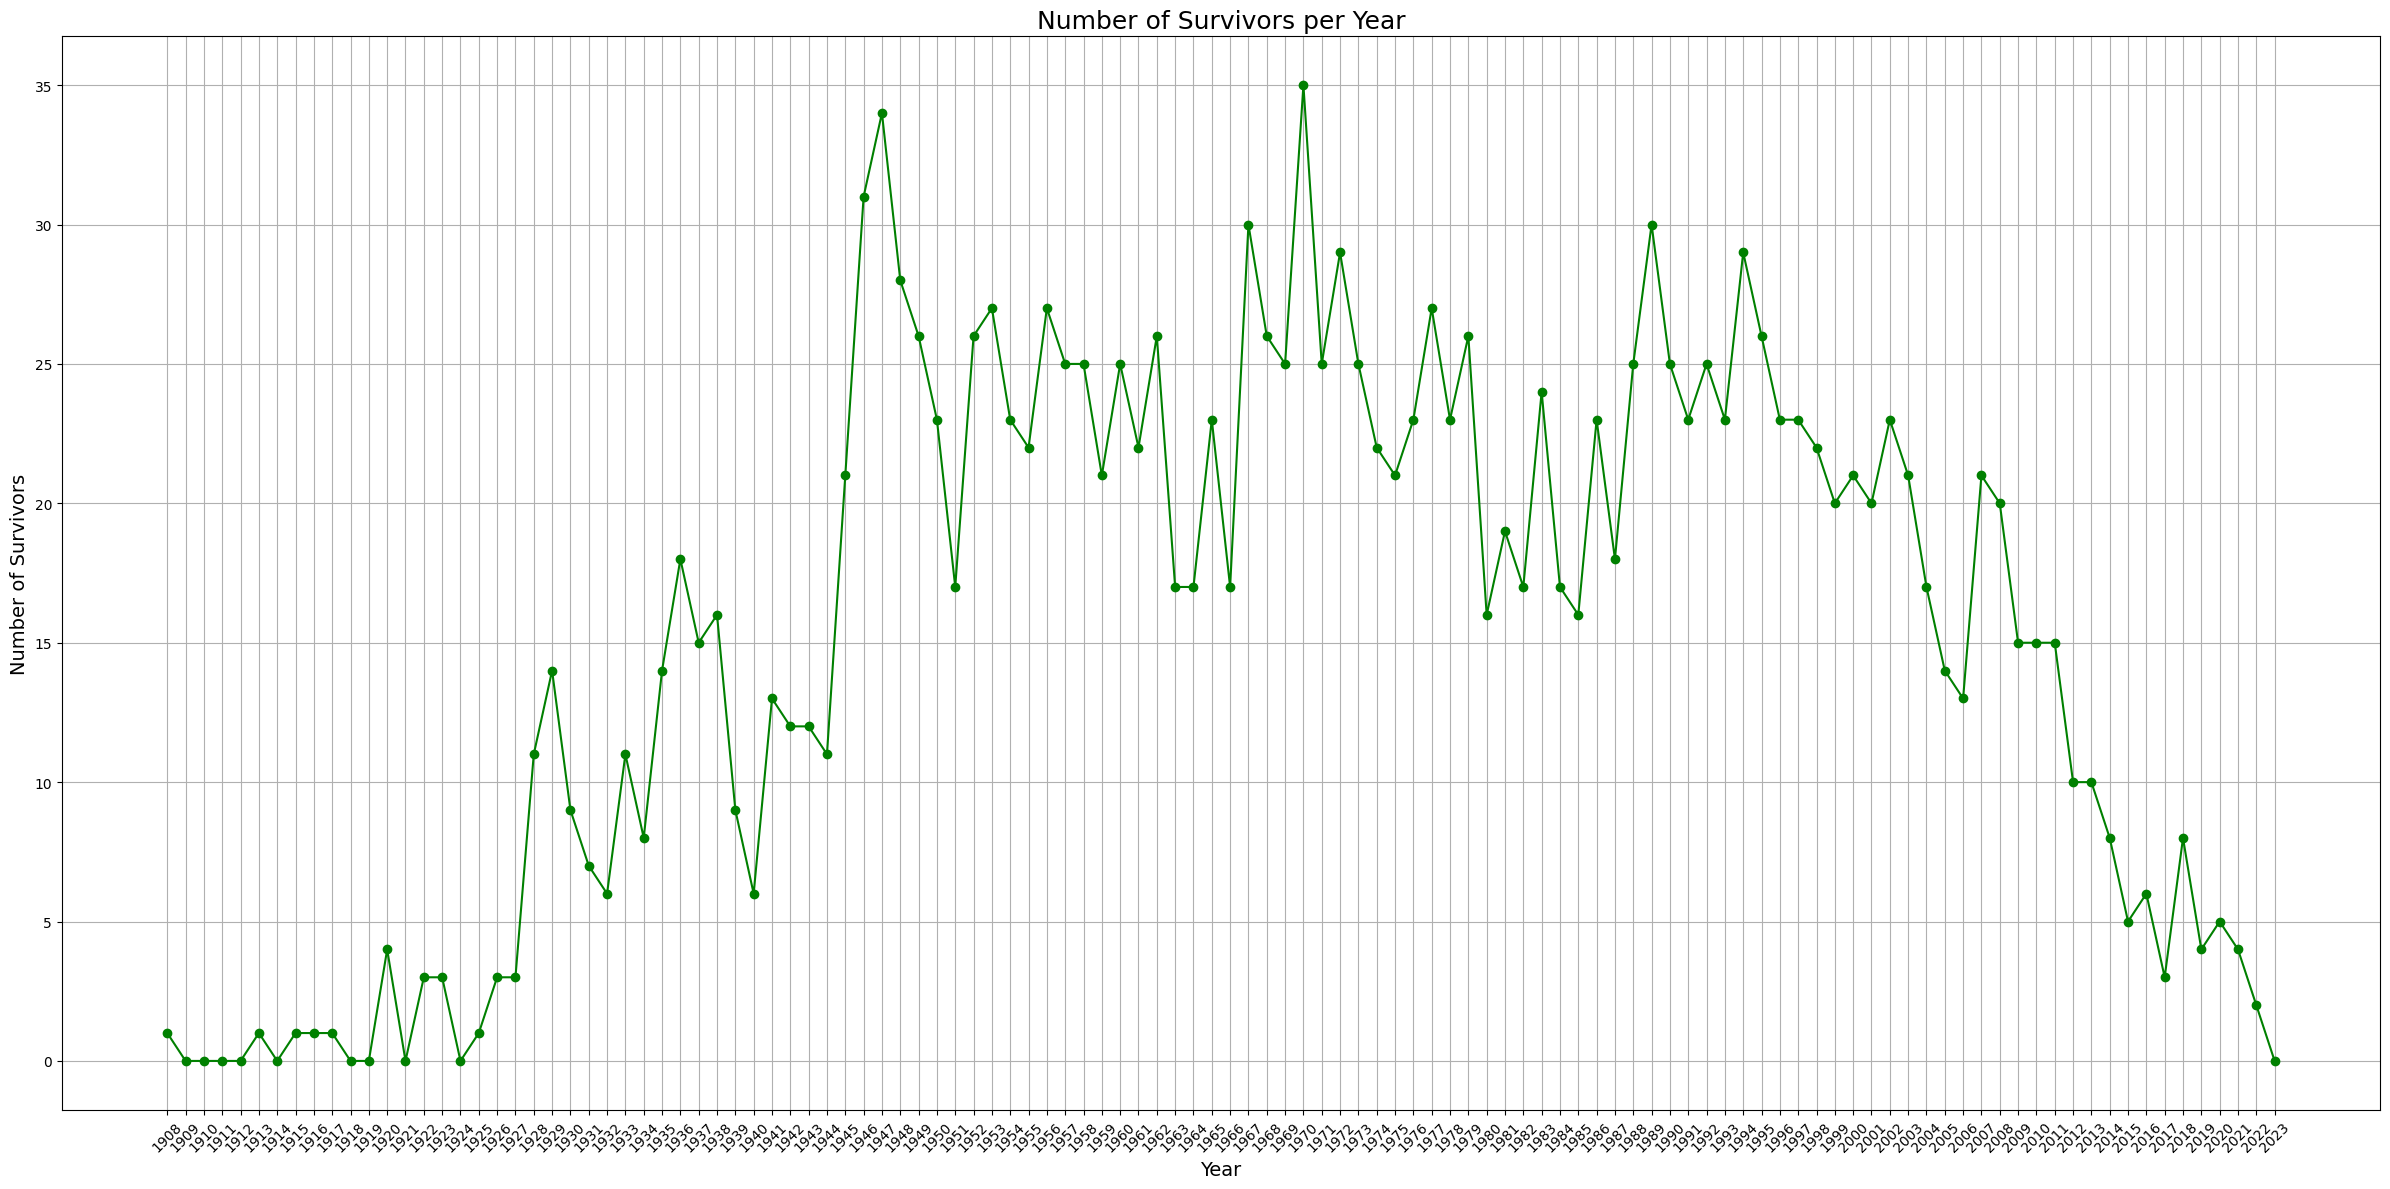

In [9]:
# Assuming 'data' is the DataFrame and 'Date' column exists with correct format
# Ensure the 'Date' column is in datetime format and extract 'Year'
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime
data['Year'] = data['Date'].dt.year  # Extract the year from the 'Date'

# Check for missing or invalid values in 'Year'
data = data.dropna(subset=['Year'])

# Calculate the total number of survivors per year
data['Survival'] = data['Aboard'] - data['Fatalities']
data['Survived'] = (data['Survival'] > 0).astype(int)

# Create a full range of years from the minimum to the maximum year in the dataset
all_years = pd.Series(range(data['Year'].min(), data['Year'].max() + 1))

# Sum the number of survivors per year
survivors_per_year = data.groupby('Year')['Survived'].sum().reindex(all_years, fill_value=0)

# Visualize the total number of survivors per year
plt.figure(figsize=(24, 12))
plt.plot(survivors_per_year.index, survivors_per_year.values, marker='o', color='green')
plt.title('Number of Survivors per Year', fontsize=18)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Survivors', fontsize=14)
plt.xticks(survivors_per_year.index, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


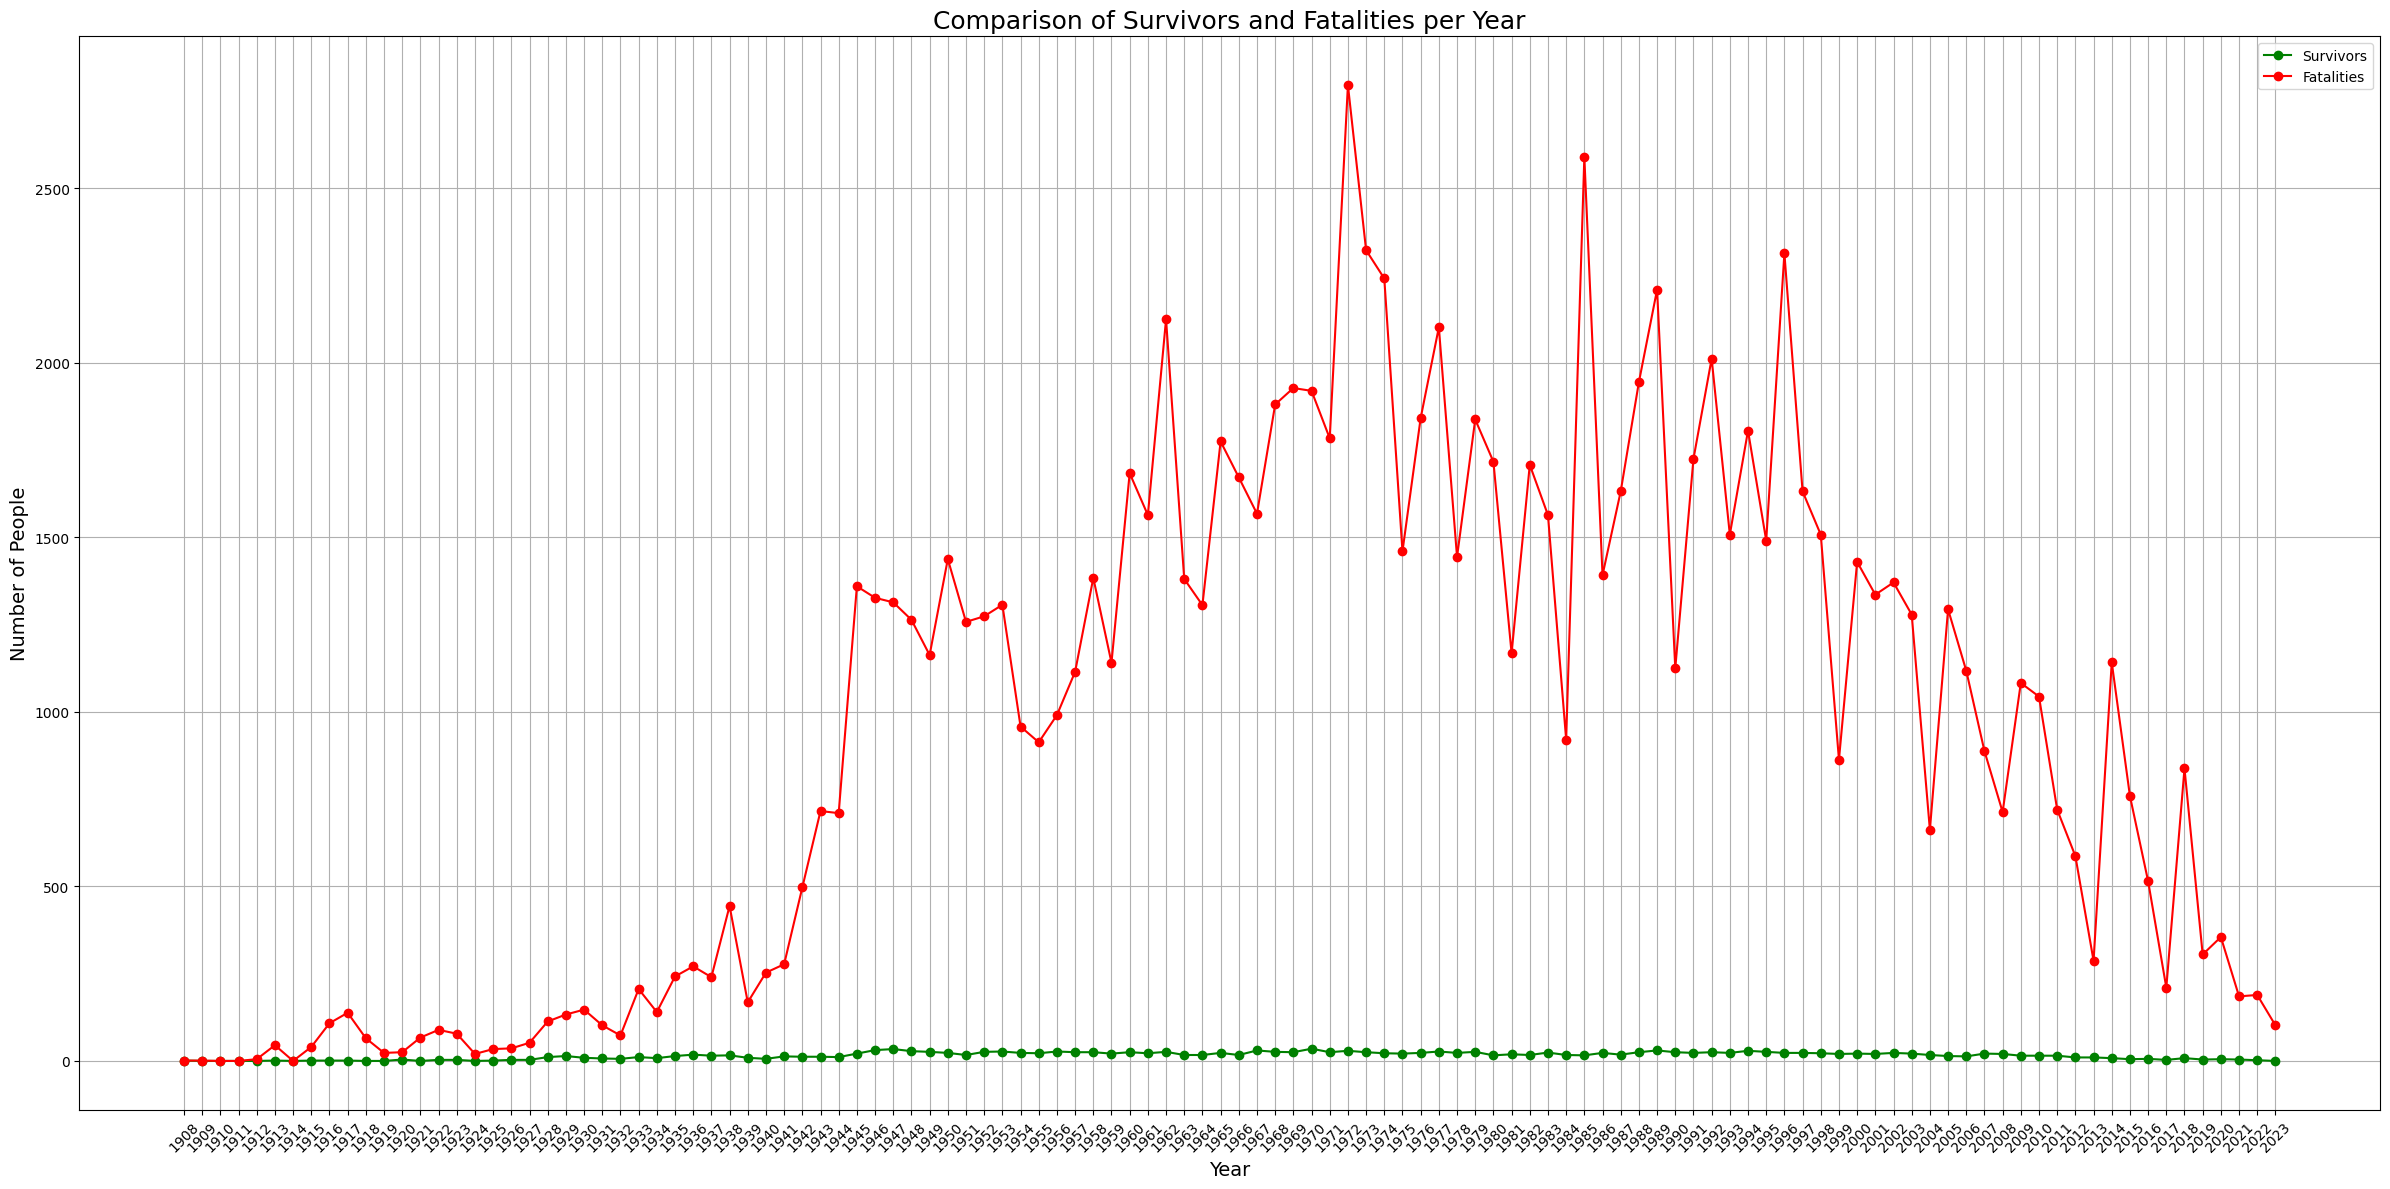

In [10]:
# Calculate the total number of fatalities per year
data['Fatalities']
# Ensure the 'Date' column is in datetime format and extract 'Year'
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime
data['Year'] = data['Date'].dt.year  # Extract the year from the 'Date'

# Check for missing or invalid values in 'Year'
data = data.dropna(subset=['Year'])

# Calculate the total number of survivors per year
data['Survival'] = data['Aboard'] - data['Fatalities']
data['Survived'] = (data['Survival'] > 0).astype(int)

# Sum the number of fatalities per year
fatalities_per_year = data.groupby('Year')['Fatalities'].sum().reindex(all_years, fill_value=0)

# Visualize the total number of fatalities per year alongside survivors
plt.figure(figsize=(24, 12))

# Plot survivors
plt.plot(survivors_per_year.index, survivors_per_year.values, marker='o', color='green', label='Survivors')

# Plot fatalities
plt.plot(fatalities_per_year.index, fatalities_per_year.values, marker='o', color='red', label='Fatalities')

# Title and labels
plt.title('Comparison of Survivors and Fatalities per Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.xticks(survivors_per_year.index, rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


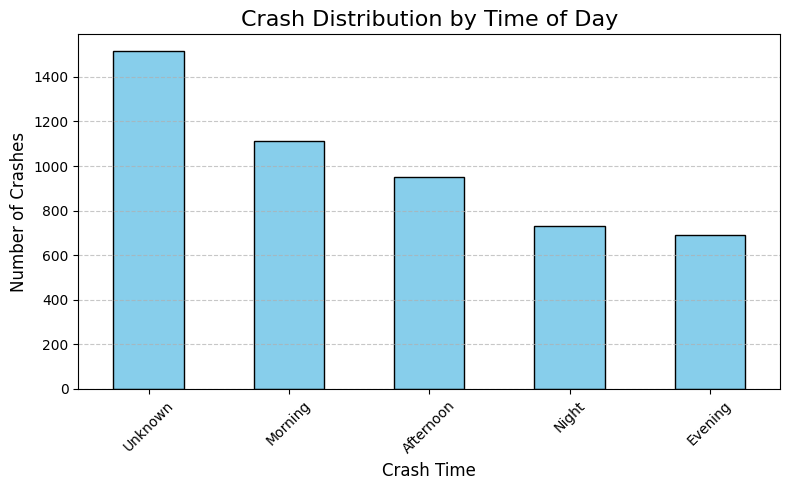

In [11]:
def categorize_time(time_str):
    if pd.isnull(time_str) or time_str.strip() == "00:00":
        return 'Unknown'
    try:
        hour = int(time_str.split(':')[0])
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    except ValueError:
        return 'Unknown'

data['Crash_Time'] = data['Time'].apply(categorize_time)

time_counts = data['Crash_Time'].value_counts()

# Bar Chart
plt.figure(figsize=(8, 5))
time_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Crash Distribution by Time of Day', fontsize=16)
plt.xlabel('Crash Time', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



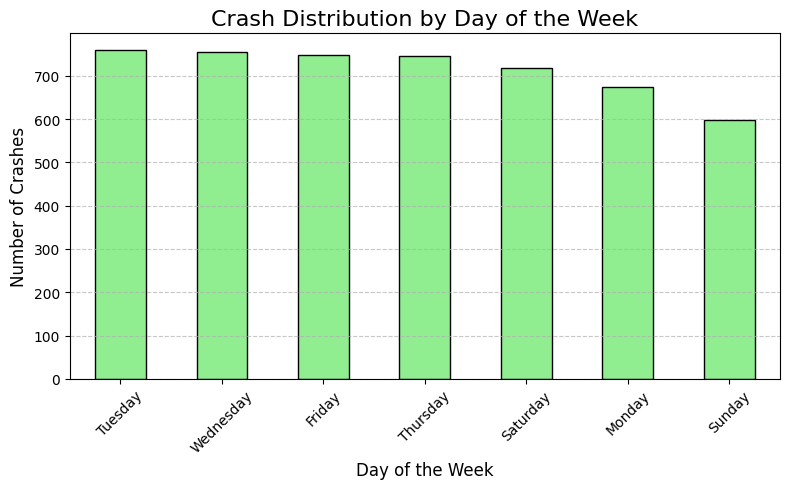

In [12]:
data['Crash_Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Day_of_Week'] = data['Crash_Date'].dt.day_name()

# Count occurrences of each day
day_counts = data['Day_of_Week'].value_counts()

# Bar Chart
plt.figure(figsize=(8, 5))
day_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Crash Distribution by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# After we have done this step, we can prepair the data to train the model
**You can find the Data Preparation in the third notebook** ***model-preparation.ipynb***